# NER and Classification with LLMs

## Install and configure OLLama with an appropriate LLM model

In [ ]:
#Download ollama
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) 
#Download model
!ollama pull llama3.1
!pip install ollama

In [3]:
from datasets import load_dataset
import pandas as pd
import spacy
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None) 

## Take 1 thousand random passages from the FIQA-PL corpus. 

In [4]:
corpus = load_dataset("clarin-knext/fiqa-pl", "corpus")['corpus'].to_pandas()
samples = corpus.sample(n=1000, random_state=42)

README.md:   0%|          | 0.00/201 [00:00<?, ?B/s]

fiqa-pl.py:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/57638 [00:00<?, ? examples/s]

In [5]:
samples

,_id,title,text
32617,337302,,">To nie różni się od Arthura Andersena. Kiedy twoje imię zostanie nadszarpnięte w tego rodzaju branży, tak naprawdę nie ma już drogi powrotnej. Nie wiem. Arthur Anderson miał wiele skandali księgowych przed Enronem. Afera z gospodarką odpadami. Myślę, że firmy takie jak Enron chciały Andersona, ponieważ były skłonne naginać zasady i działać w szarej strefie. Tym, co zabiło Arthura Andersona, nie był ich pobieżny audyt. To ich gówniany prawnik wpadł w szał Bonanzy, kiedy stało się jasne, że Enron upadnie. Sprawa tuszowania jest gorsza niż przestępstwo."
224,2456,,"W Stanach Zjednoczonych możesz wejść do niektórych sklepów detalicznych i zapłacić bezpośrednio za pomocą PayPal. Niektóre z nich sprzedają przedpłaconą kartę debetową. O jeden i użyj go, aby zapłacić rachunek. Jeśli nie jesteś w USA - sprawdź, czy zezwalają na to lokalni sprzedawcy. Wierzę, że w Wielkiej Brytanii mają też takie, które pozwalają na paypal."
6623,68389,,"Cóż, gdybyśmy mieli demokrację, to ludzie są tymi, którzy muszą działać, aby rząd był odpowiedzialny. Ale w naszym społeczeństwie duże interesy ekonomiczne mają wpływ na rząd, więc mamy plutokrację. Więc to właśnie przeszkadza ludziom, którzy rozliczają swój rząd."
14005,144158,,"Właściwie to ma sens. Jeśli rząd ma mniejszy wpływ na krajową gospodarkę, wielki biznes nie będzie miał powodu, by go infiltrować. Teraz, jeśli uda nam się to zrobić, a potem ponownie przeznaczyć te dotacje na reformy społeczne, to może być miłe."
49565,514970,,"Nie wspomniałeś o kraju, a dokładne zasady będą się różnić w zależności od kraju. Zwykłe zasady to: Akcje, których nie sprzedałeś, nie liczą się. Jeśli kupisz akcje, nie otrzymasz dochodu podlegającego opodatkowaniu, dopóki ich nie sprzedasz. Kiedy sprzedajesz akcje, zakłada się, że akcje, które sprzedajesz, są ostatnimi, które kupiłeś. W wielu miejscach, jeśli sprzedasz akcje i bardzo szybko je odkupisz, urząd skarbowy może mieć zasady, które będą udawać, że nigdy ich nie sprzedałeś. Na przykład w Wielkiej Brytanii, gdzie duża część zysku rocznie jest wolna od podatku, nie możesz po prostu sprzedać wystarczającej liczby akcji, aby utrzymać się poniżej limitu podatkowego, a następnie odkupić je, aby czerpać zyski z posiadanych akcji. W twoim przypadku zarobiłeś 30 USD na każdej sprzedanej akcji i od tego będziesz opodatkowany w większości krajów. Zgodnie z przepisami obowiązującymi w Twoim kraju."
...,...,...,...
40577,422579,,"Zależy to od warunków najmu, ale trudno wyobrazić sobie leasing, który pozwalałby na to jednostronnie, bez żadnych zobowiązań. Oznacza to, że tak naprawdę zależy to nie od tego, jak bardzo lubisz swoją gospodynię, ale od tego, jak bardzo ona lubi ciebie. Generalnie, podpisując umowę najmu, przyjmujesz zobowiązanie umowne do comiesięcznego płacenia czynszu przez cały okres najmu. Teoretycznie możesz zostać pozwany, jeśli tego nie zrobisz. W praktyce wiele zależy od twoich relacji z wynajmującym, a także od rynku wynajmu w Twojej okolicy. Jeśli właściciel z łatwością znajdzie zastępczego najemcę, może chcieć umożliwić wcześniejsze opuszczenie lokalu. Jeśli rynek wynajmu jest powolny, będą bardziej skłonni trzymać Cię do porozumienia. Oczywiście, jeśli masz dobre stosunki z właścicielem, może on być bardziej skłonny do pobłażania ci. Jeśli chodzi o poinformowanie gospodyni, że chcesz wcześniej rozwiązać umowę najmu, chyba że jest szczególnie nieprzyjemną osobą, możesz po prostu powiedzieć jej, że chcesz wcześniej wyjechać. To, czego nie możesz zrobić, to przestać płacić czynsz. Jeśli jesteś w dość dobrych stosunkach ze swoją gospodynią, możesz po prostu powiedzieć jej o swojej sytuacji i powiedzieć, że chcesz się wyprowadzić. Może chcieć wypracować układ, w którym wymieni mieszkanie, gdy nadal tam mieszkasz, pozwoli potencjalnym najemcom zobaczyć je, gdy jest zajęte, a następnie wyprowadzi się, jeśli i kiedy ktoś inny będzie chciał się wprowadzić (np. pod koniec miesiąca). Ponownie, dokładnie, jak to działa, będzie pr

## As baseline use traditional NER methods from lab 7 - SpaCy.

In [6]:
!python -m spacy download pl_core_news_sm
nlp = spacy.load("pl_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 77.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [7]:
classes = defaultdict(lambda: [defaultdict(int), 0])

def add_element_to_class(classes, ent_label, ent_lemma):
    classes[ent_label][0][ent_lemma] += 1 
    classes[ent_label][1] += 1  

spacy_results = []

for document in samples['text']:
    doc = nlp(document)
    entities_dict = defaultdict(list)

    for ent in doc.ents:
        add_element_to_class(classes, ent.label_, ent.lemma_)
        entities_dict[ent.label_].append(ent.lemma_)

    formatted_entities = [f"{label}: {', '.join(set(entities))}" for label, entities in entities_dict.items()]

    spacy_results.append({
        'text': document,
        'entities': "; ".join(formatted_entities)  
    })


In [8]:
spacy_results_df = pd.DataFrame(spacy_results)
spacy_results_df.to_csv('spacy_results.csv', index=False)

In [9]:
spacy_results_df[:10]

,text,entities
0,">To nie różni się od Arthura Andersena. Kiedy twoje imię zostanie nadszarpnięte w tego rodzaju branży, tak naprawdę nie ma już drogi powrotnej. Nie wiem. Arthur Anderson miał wiele skandali księgowych przed Enronem. Afera z gospodarką odpadami. Myślę, że firmy takie jak Enron chciały Andersona, ponieważ były skłonne naginać zasady i działać w szarej strefie. Tym, co zabiło Arthura Andersona, nie był ich pobieżny audyt. To ich gówniany prawnik wpadł w szał Bonanzy, kiedy stało się jasne, że Enron upadnie. Sprawa tuszowania jest gorsza niż przestępstwo.","persName: Enron, Arthura Andersena, Arthura Andersona, Arthur Anderson, Andersona; placeName: Bonanza"
1,"W Stanach Zjednoczonych możesz wejść do niektórych sklepów detalicznych i zapłacić bezpośrednio za pomocą PayPal. Niektóre z nich sprzedają przedpłaconą kartę debetową. O jeden i użyj go, aby zapłacić rachunek. Jeśli nie jesteś w USA - sprawdź, czy zezwalają na to lokalni sprzedawcy. Wierzę, że w Wielkiej Brytanii mają też takie, które pozwalają na paypal.","placeName: USA, Stany Zjednoczone, Wielki Brytania"
2,"Cóż, gdybyśmy mieli demokrację, to ludzie są tymi, którzy muszą działać, aby rząd był odpowiedzialny. Ale w naszym społeczeństwie duże interesy ekonomiczne mają wpływ na rząd, więc mamy plutokrację. Więc to właśnie przeszkadza ludziom, którzy rozliczają swój rząd.",
3,"Właściwie to ma sens. Jeśli rząd ma mniejszy wpływ na krajową gospodarkę, wielki biznes nie będzie miał powodu, by go infiltrować. Teraz, jeśli uda nam się to zrobić, a potem ponownie przeznaczyć te dotacje na reformy społeczne, to może być miłe.",
4,"Nie wspomniałeś o kraju, a dokładne zasady będą się różnić w zależności od kraju. Zwykłe zasady to: Akcje, których nie sprzedałeś, nie liczą się. Jeśli kupisz akcje, nie otrzymasz dochodu podlegającego opodatkowaniu, dopóki ich nie sprzedasz. Kiedy sprzedajesz akcje, zakłada się, że akcje, które sprzedajesz, są ostatnimi, które kupiłeś. W wielu miejscach, jeśli sprzedasz akcje i bardzo szybko je odkupisz, urząd skarbowy może mieć zasady, które będą udawać, że nigdy ich nie sprzedałeś. Na przykład w Wielkiej Brytanii, gdzie duża część zysku rocznie jest wolna od podatku, nie możesz po prostu sprzedać wystarczającej liczby akcji, aby utrzymać się poniżej limitu podatkowego, a następnie odkupić je, aby czerpać zyski z posiadanych akcji. W twoim przypadku zarobiłeś 30 USD na każdej sprzedanej akcji i od tego będziesz opodatkowany w większości krajów. Zgodnie z przepisami obowiązującymi w Twoim kraju.",placeName: Wielki Brytania
5,"Prawdy na temat recenzji BlueHost oprócz rabatów Analizując recenzje BlueHost, a także obniżki cen, można odkryć usługi hostingowe w dobrej cenie. Dla tych, którzy mają usługi i pragną pełnej funkcjonalności przy rozsądnych kosztach, BlueHost jest kompletny. Zapewnia nieograniczoną przestrzeń dyskową, przeciąganie i zmniejszanie profesjonalizmu witryny, obsługę domen na całym świecie, kontrolę cPanel, dostęp do FTP, a także wiele więcej.",persName: Analizując; orgName: FTP
6,"> - Zbyt długo czekałem na remont swoich sklepów. Między moim domem a sąsiedzką stacją kolejową znajdował się Sears, po którym przechodziłem regularnie przez dwa lata, zanim zdałem sobie sprawę, że to sklep operacyjny, a nie opuszczony magazyn.",persName: Sears
7,"Głównym powodem, dla którego ludzie wybierają rachunki o niższym oprocentowaniu, jest wygoda posiadania pieniędzy w tej samej instytucji z innymi kontami (takimi jak czeki, pożyczki samochodowe, karty kredytowe itp.) w lokalnym banku. Te internetowe konta oszczędnościowe są regulowane przez prawo i zezwalają tylko na 6 przelewów miesięcznie, więc dla osób, które muszą częściej dokonywać wypłat, może to być również czynnikiem. Jeśli ktoś ma takie konto, które nie jest częścią jego normalnego konta czekowego, może być niewygodne czekanie na zakończenie ACH przez noc, zanim środki będą dostępne na jego głównych kontach. Z pewnością korzystam z konta o wyższej rentowności, aby uzyskać b

In [10]:
for label, (lemmas, total_tokens) in classes.items():
    print(f"Class label: {label}")
    print(f"  Tokens frequency: {dict(lemmas)}")
    print(f"  Sum of tokens in class: {total_tokens}")

Class label: persName
  Tokens frequency: {'Arthura Andersena': 1, 'Arthur Anderson': 2, 'Enron': 2, 'Andersona': 1, 'Arthura Andersona': 1, 'Analizując': 1, 'Sears': 3, "Steve'e Jobs": 1, 'Steve Jobs': 1, 'Capital on': 1, 'Jacek Bogle': 1, 'S-Corp': 2, 'Netflix': 7, 'makarov': 1, 'D.': 3, 'V.': 2, 'Parovik': 1, 'R.': 1, 'F.': 1, 'Francis': 1, 'N.': 1, 'A.': 2, 'XX': 1, 'Gold Margin': 1, 'Money': 5, 'Quicken': 5, 'ETFy': 1, 'BankSimple': 2, 'Kaplan': 1, 'Amazon': 17, 'Joe': 1, 'paypal': 1, 'French': 1, 'Damodaran': 1, 'Warren Buffet': 2, 'Vanguard REIT': 1, 'McKinsey': 1, 'G.': 1, 'Edward Griffin': 1, 'Stackexchange': 1, 'Zastanawiać': 1, 'Bob': 4, 'Recovery Centers': 1, 'biznes Amazona': 1, 'Jean-Jacque Sergen-Schreiber': 1, 'John Templeton': 1, 'John Train': 1, 'wycena': 1, 'musiałbyś': 3, 'Canyonero': 1, 'Neala': 1, 'SmartHold': 2, 'Kayak Carrier': 1, 'Salter': 2, 'Schwab': 2, 'Vanguard': 5, 'Cash ISA': 2, 'MoneySavingExpert': 1, 'miro': 1, '„': 1, 'Zoom': 1, 'Recycle Metals': 1, 'm

## Use LLM model for NER

In [11]:
import ollama
zero_shot_prompt = '''
    Identify the named entities in the following text and classify them into categories:  
    Categories: 'date', 'geogName', 'orgName', 'persName', 'placeName', 'time'  

    Category descriptions:  
    - date: Specific calendar dates mentioned in the text.  
    - geogName: Names of geographical locations such as continents, regions, seas, oceans, mountain ranges.  
    - orgName: Names of organizations, institutions, or companies.  
    - persName: Names of specific people, whether historical, fictional, or contemporary.  
    - placeName: Names of specific places like countries, cities, towns, landmarks.  
    - time: Specific times mentioned in the text.  

    Please provide the response in the following format:  
    category1_name: entity_name
    category2_name: entity_name 

    If there are multiple entities matching one category, separate them with a comma.  
    Do not create any additional categories beyond 'date', 'geogName', 'orgName', 'persName', 'placeName', 'time'.  
    If there is no matching entity for a category, simply do not include that category in your answer.  
    Do not provide any additional information beyond "category_name: entity_name".  
    In place of "entity_name", put only entities from the provided text, and do not generate any additional content that doesn't appear in the text.  
    If there aren't any named entities in the text, just put "" in the answer.  
'''

few_shot_prompt = '''
    Identify the named entities in the following text and classify them into categories:  
    Categories: 'date', 'geogName', 'orgName', 'persName', 'placeName', 'time'  

    Category descriptions:  
    - date: Specific calendar dates mentioned in the text.  
    - geogName: Names of geographical locations such as continents, regions, seas, oceans, mountain ranges.  
    - orgName: Names of organizations, institutions, or companies.  
    - persName: Names of specific people, whether historical, fictional, or contemporary.  
    - placeName: Names of specific places like countries, cities, towns, landmarks.  
    - time: Specific times mentioned in the text.  

    The following examples show how to process provided texts::

    Examples: 

    Example 1  
    Text:
    "Międzynarodowy Fundusz Walutowy (IMF) ogłosił prognozy wzrostu PKB dla Europy Środkowo-Wschodniej na 2024 rok. 
    W raporcie znalazły się dane dotyczące Polski, Czech i Węgier, a konferencja prasowa odbyła się 3 kwietnia 2024 roku o godzinie 10:00."  
    **Response:**  
    date: 2024, 3 kwietnia 2024  
    geogName: Europa Środkowo-Wschodnia  
    orgName: Międzynarodowy Fundusz Walutowy (IMF)  
    placeName: Polska, Czechy, Węgry  
    time: 10:00 
    
    Example 2 
    Text:
    "Apple zaprezentowało nowy iPhone 15 Pro w trakcie dorocznego wydarzenia, które odbyło się 12 września 2023 roku w Cupertino. Tim Cook, dyrektor generalny firmy, omówił nowości produktowe i plany rozwoju na kolejne lata."  
    Response: 
    date: 12 września 2023  
    orgName: Apple  
    persName: Tim Cook  
    placeName: Cupertino

    Example 3
    Text: 
    "W trakcie rejsu przez Ocean Atlantycki kapitan James Cook odkrył wyspę, którą nazwał Nową Zelandią. Było to w 1769 roku, podczas jego pierwszej ekspedycji morskiej."  
    Response:  
    date: 1769  
    geogName: Ocean Atlantycki  
    persName: James Cook  
    placeName: Nowa Zelandia  


    Do not create any additional categories beyond 'date', 'geogName', 'orgName', 'persName', 'placeName', 'time'.  
    If there is no matching entity for a category, simply do not include that category in your answer.  
    Do not provide any additional information beyond "category_name: entity_name".  
    In place of "entity_name", put only entities from the provided text, and do not generate any additional content that doesn't appear in the text.  
    If there aren't any named entities in the text, just put "" in the answer.  
'''



In [12]:

def extract_entities_from_text(text, prompt):
    try:
        response = ollama.chat(model='llama3.1', messages=[
            {
                'role': 'user',
                'content': f"""
                {prompt}
                Text: '{text}'
                """
            },
        ])
        return response['message']['content']
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

In [13]:
import re
def extract_valid_entities(response):
    valid_entities = []
    lines = response.split("\n")
    
    for line in lines:
        line = line.strip()
        line = re.sub(r'^\*{2}|\*{2}', '', line)
        if line: 
            match = re.match(r'(\w+):\s*(.*)', line)
            if match:
                category, entity = match.groups()
                entity = entity.strip() 
                if entity and entity.lower() not in {'none', ' '} and not entity.lower().startswith('nie'):
                    valid_entities.append(f"{category}: {entity}")
    
    return "; ".join(valid_entities)

### Zero-shot prompting

In [ ]:
llm_results = []
for i, text in enumerate(samples['text']):
    print(f"Processing sample {i+1}/{len(samples)}")
    response = extract_entities_from_text(text, zero_shot_prompt)
    #print(response)
    llm_results.append({
        'text': text,
        'entities': extract_valid_entities(response)
    })

In [33]:
zero_shot_results_df = pd.DataFrame(llm_results)
zero_shot_results_df.to_csv('zero_shot_results.csv', index=False)

In [34]:
zero_shot_results_df

,text,entities
0,">To nie różni się od Arthura Andersena. Kiedy twoje imię zostanie nadszarpnięte w tego rodzaju branży, tak naprawdę nie ma już drogi powrotnej. Nie wiem. Arthur Anderson miał wiele skandali księgowych przed Enronem. Afera z gospodarką odpadami. Myślę, że firmy takie jak Enron chciały Andersona, ponieważ były skłonne naginać zasady i działać w szarej strefie. Tym, co zabiło Arthura Andersona, nie był ich pobieżny audyt. To ich gówniany prawnik wpadł w szał Bonanzy, kiedy stało się jasne, że Enron upadnie. Sprawa tuszowania jest gorsza niż przestępstwo.","persName: Arthur Anderson, Arthur Andersena; orgName: Enron"
1,"W Stanach Zjednoczonych możesz wejść do niektórych sklepów detalicznych i zapłacić bezpośrednio za pomocą PayPal. Niektóre z nich sprzedają przedpłaconą kartę debetową. O jeden i użyj go, aby zapłacić rachunek. Jeśli nie jesteś w USA - sprawdź, czy zezwalają na to lokalni sprzedawcy. Wierzę, że w Wielkiej Brytanii mają też takie, które pozwalają na paypal.","geogName: Stany Zjednoczone, Wielka Brytania; orgName: PayPal; placeName: USA, Wielka Brytania"
2,"Cóż, gdybyśmy mieli demokrację, to ludzie są tymi, którzy muszą działać, aby rząd był odpowiedzialny. Ale w naszym społeczeństwie duże interesy ekonomiczne mają wpływ na rząd, więc mamy plutokrację. Więc to właśnie przeszkadza ludziom, którzy rozliczają swój rząd.",
3,"Właściwie to ma sens. Jeśli rząd ma mniejszy wpływ na krajową gospodarkę, wielki biznes nie będzie miał powodu, by go infiltrować. Teraz, jeśli uda nam się to zrobić, a potem ponownie przeznaczyć te dotacje na reformy społeczne, to może być miłe.",
4,"Nie wspomniałeś o kraju, a dokładne zasady będą się różnić w zależności od kraju. Zwykłe zasady to: Akcje, których nie sprzedałeś, nie liczą się. Jeśli kupisz akcje, nie otrzymasz dochodu podlegającego opodatkowaniu, dopóki ich nie sprzedasz. Kiedy sprzedajesz akcje, zakłada się, że akcje, które sprzedajesz, są ostatnimi, które kupiłeś. W wielu miejscach, jeśli sprzedasz akcje i bardzo szybko je odkupisz, urząd skarbowy może mieć zasady, które będą udawać, że nigdy ich nie sprzedałeś. Na przykład w Wielkiej Brytanii, gdzie duża część zysku rocznie jest wolna od podatku, nie możesz po prostu sprzedać wystarczającej liczby akcji, aby utrzymać się poniżej limitu podatkowego, a następnie odkupić je, aby czerpać zyski z posiadanych akcji. W twoim przypadku zarobiłeś 30 USD na każdej sprzedanej akcji i od tego będziesz opodatkowany w większości krajów. Zgodnie z przepisami obowiązującymi w Twoim kraju.",geogName: Wielka Brytania
...,...,...
995,"Zależy to od warunków najmu, ale trudno wyobrazić sobie leasing, który pozwalałby na to jednostronnie, bez żadnych zobowiązań. Oznacza to, że tak naprawdę zależy to nie od tego, jak bardzo lubisz swoją gospodynię, ale od tego, jak bardzo ona lubi ciebie. Generalnie, podpisując umowę najmu, przyjmujesz zobowiązanie umowne do comiesięcznego płacenia czynszu przez cały okres najmu. Teoretycznie możesz zostać pozwany, jeśli tego nie zrobisz. W praktyce wiele zależy od twoich relacji z wynajmującym, a także od rynku wynajmu w Twojej okolicy. Jeśli właściciel z łatwością znajdzie zastępczego najemcę, może chcieć umożliwić wcześniejsze opuszczenie lokalu. Jeśli rynek wynajmu jest powolny, będą bardziej skłonni trzymać Cię do porozumienia. Oczywiście, jeśli masz dobre stosunki z właścicielem, może on być bardziej skłonny do pobłażania ci. Jeśli chodzi o poinformowanie gospodyni, że chcesz wcześniej rozwiązać umowę najmu, chyba że jest szczególnie nieprzyjemną osobą, możesz po prostu powiedzieć jej, że chcesz wcześniej wyjechać. To, czego nie możesz zrobić, to przestać płacić czynsz. Jeśli jesteś w dość dobrych stosunkach ze swoją gospodynią, możesz po prostu powiedzieć jej o swojej sytuacji i powiedzieć, że chcesz się wyprowadzić. Może chcieć wypracować układ, w którym wymieni mieszkanie, gdy nadal tam mieszkasz, pozwoli potencjalnym najemcom zobaczyć je, gdy jest zajęte, a następnie wyprowadzi się, jeśli i

In [19]:
def process_entities(entities_text):
    entities = []
    if not entities_text:
        return entities
    for line in entities_text.split("; "):
        if ": " in line:
            entity_class, entity_names = line.split(": ", 1)  
            entity_list = [name.strip() for name in entity_names.split(",") if name.strip()]
            entities.extend([(entity_class.strip(), entity_name) for entity_name in entity_list])
    return entities

In [36]:
zero_shot_classes = defaultdict(lambda: [defaultdict(int), 0])

In [37]:
for entity_text in zero_shot_results_df['entities']:
    entities = process_entities(entity_text)
    for entity_class, entity_name in entities:
        zero_shot_classes[entity_class][0][entity_name] += 1  
        zero_shot_classes[entity_class][1] += 1 

In [38]:
for label, (lemmas, total_tokens) in zero_shot_classes.items():
    print(f"Class label: {label}")
    print(f"  Tokens frequency: {dict(lemmas)}")
    print(f"  Sum of tokens in class: {total_tokens}")

Class label: persName
  Tokens frequency: {'Arthur Anderson': 2, 'Arthur Andersena': 1, 'Zbyt (imię osoby w tekście': 1, 'może być błędem': 1, 'imienia nie podano)': 1, 'Steve Jobs': 3, 'Jacek Bogle': 1, 'I': 1, 'S': 1, 'Makarov': 1, 'D. V.': 1, 'Parovik': 1, 'R. I.': 1, 'Beaudry': 1, 'P.': 1, 'Portier': 1, 'F.': 1, 'Francis': 1, 'N.': 1, 'Ramey': 1, 'V.A.': 1, 'żona': 3, "osoba z firmy (note: this is a generic phrase and not a specific person's name)": 1, 'kto': 1, 'Joe': 2, 'karim': 1, 'Fama': 1, 'French': 1, 'Damodaran': 1, 'Buffet': 1, 'G. Edward Griffin': 1, 'Jako': 1, 'matka': 2, 'ojciec': 1, 'Bernie Sanders': 2, 'drugi facet': 1, 'twoi': 1, 'FRANCUSZA Jean-Jacque Sergen-Schreiber': 1, 'John Templeton': 1, 'John Traina': 1, 'Neal Stephenson': 1, 'VIC Recycle Metals': 1, 'Edytuj': 1, 'nie': 1, 'nieznane imiona są znaczone jako "nieznane"': 1, 'nie są one istotne w tej sytuacji. Wyjątkiem jest Edytuj.': 1, 'Uber/Lyft': 1, 'taksówki': 1, 'ja': 4, 'Hyman Minsky': 1, 'Ian Lyngen': 1, 

### Few-shot prompting 

In [ ]:
llm_results = []
for i, text in enumerate(samples['text']):
    print(f"Processing sample {i+1}/{len(samples)}")
    response = extract_entities_from_text(text, few_shot_prompt)
    #print(response)
    llm_results.append({
        'text': text,
        'entities': extract_valid_entities(response)
    })

In [15]:
few_shot_results_df = pd.DataFrame(llm_results)
few_shot_results_df.to_csv('few_shot_results.csv', index=False)

In [16]:
few_shot_results_df

,text,entities
0,">To nie różni się od Arthura Andersena. Kiedy twoje imię zostanie nadszarpnięte w tego rodzaju branży, tak naprawdę nie ma już drogi powrotnej. Nie wiem. Arthur Anderson miał wiele skandali księgowych przed Enronem. Afera z gospodarką odpadami. Myślę, że firmy takie jak Enron chciały Andersona, ponieważ były skłonne naginać zasady i działać w szarej strefie. Tym, co zabiło Arthura Andersona, nie był ich pobieżny audyt. To ich gówniany prawnik wpadł w szał Bonanzy, kiedy stało się jasne, że Enron upadnie. Sprawa tuszowania jest gorsza niż przestępstwo.","orgName: Anderson, Arthur"
1,"W Stanach Zjednoczonych możesz wejść do niektórych sklepów detalicznych i zapłacić bezpośrednio za pomocą PayPal. Niektóre z nich sprzedają przedpłaconą kartę debetową. O jeden i użyj go, aby zapłacić rachunek. Jeśli nie jesteś w USA - sprawdź, czy zezwalają na to lokalni sprzedawcy. Wierzę, że w Wielkiej Brytanii mają też takie, które pozwalają na paypal.","orgName: PayPal; placeName: Stany Zjednoczone, Wielka Brytania"
2,"Cóż, gdybyśmy mieli demokrację, to ludzie są tymi, którzy muszą działać, aby rząd był odpowiedzialny. Ale w naszym społeczeństwie duże interesy ekonomiczne mają wpływ na rząd, więc mamy plutokrację. Więc to właśnie przeszkadza ludziom, którzy rozliczają swój rząd.",
3,"Właściwie to ma sens. Jeśli rząd ma mniejszy wpływ na krajową gospodarkę, wielki biznes nie będzie miał powodu, by go infiltrować. Teraz, jeśli uda nam się to zrobić, a potem ponownie przeznaczyć te dotacje na reformy społeczne, to może być miłe.",
4,"Nie wspomniałeś o kraju, a dokładne zasady będą się różnić w zależności od kraju. Zwykłe zasady to: Akcje, których nie sprzedałeś, nie liczą się. Jeśli kupisz akcje, nie otrzymasz dochodu podlegającego opodatkowaniu, dopóki ich nie sprzedasz. Kiedy sprzedajesz akcje, zakłada się, że akcje, które sprzedajesz, są ostatnimi, które kupiłeś. W wielu miejscach, jeśli sprzedasz akcje i bardzo szybko je odkupisz, urząd skarbowy może mieć zasady, które będą udawać, że nigdy ich nie sprzedałeś. Na przykład w Wielkiej Brytanii, gdzie duża część zysku rocznie jest wolna od podatku, nie możesz po prostu sprzedać wystarczającej liczby akcji, aby utrzymać się poniżej limitu podatkowego, a następnie odkupić je, aby czerpać zyski z posiadanych akcji. W twoim przypadku zarobiłeś 30 USD na każdej sprzedanej akcji i od tego będziesz opodatkowany w większości krajów. Zgodnie z przepisami obowiązującymi w Twoim kraju.","geogName: Europa Środkowo-Wschodnia, Ocean Atlantycki; orgName: Międzynarodowy Fundusz Walutowy (IMF), urząd skarbowy; placeName: Polska, Czechy, Węgry, Wielka Brytania, Nowa Zelandia"
...,...,...
995,"Zależy to od warunków najmu, ale trudno wyobrazić sobie leasing, który pozwalałby na to jednostronnie, bez żadnych zobowiązań. Oznacza to, że tak naprawdę zależy to nie od tego, jak bardzo lubisz swoją gospodynię, ale od tego, jak bardzo ona lubi ciebie. Generalnie, podpisując umowę najmu, przyjmujesz zobowiązanie umowne do comiesięcznego płacenia czynszu przez cały okres najmu. Teoretycznie możesz zostać pozwany, jeśli tego nie zrobisz. W praktyce wiele zależy od twoich relacji z wynajmującym, a także od rynku wynajmu w Twojej okolicy. Jeśli właściciel z łatwością znajdzie zastępczego najemcę, może chcieć umożliwić wcześniejsze opuszczenie lokalu. Jeśli rynek wynajmu jest powolny, będą bardziej skłonni trzymać Cię do porozumienia. Oczywiście, jeśli masz dobre stosunki z właścicielem, może on być bardziej skłonny do pobłażania ci. Jeśli chodzi o poinformowanie gospodyni, że chcesz wcześniej rozwiązać umowę najmu, chyba że jest szczególnie nieprzyjemną osobą, możesz po prostu powiedzieć jej, że chcesz wcześniej wyjechać. To, czego nie możesz zrobić, to przestać płacić czynsz. Jeśli jesteś w dość dobrych stosunkach ze swoją gospodynią, możesz po prostu powiedzieć jej o swojej sytuacji i powiedzieć, że chcesz się wyprowadzić. Może chcieć wypracować układ, w którym wymieni mieszkanie, gdy nadal tam mieszkasz, p

In [17]:
few_shot_classes = defaultdict(lambda: [defaultdict(int), 0])

In [20]:
for entity_text in few_shot_results_df['entities']:
    entities = process_entities(entity_text)
    for entity_class, entity_name in entities:
        few_shot_classes[entity_class][0][entity_name] += 1  
        few_shot_classes[entity_class][1] += 1 

In [21]:
for label, (lemmas, total_tokens) in few_shot_classes.items():
    print(f"Class label: {label}")
    print(f"  Tokens frequency: {dict(lemmas)}")
    print(f"  Sum of tokens in class: {total_tokens}")

Class label: orgName
  Tokens frequency: {'Anderson': 1, 'Arthur': 1, 'PayPal': 4, 'Międzynarodowy Fundusz Walutowy (IMF)': 17, 'urząd skarbowy': 1, 'BlueHost': 1, 'Sears': 3, 'Just your fitness': 1, 'Everbank': 1, 'About.com': 1, 'Capital One': 1, 'IRS': 16, 'firma 401k': 1, 'HR (nie jest wyraźnie określona jako nazwa organizacji)': 1, 'Apple': 7, 'Google': 8, 'Tesla': 2, 'GE': 2, 'Microsoft': 6, 'Netflix': 6, 'Comcast': 4, 'Eu-JR': 1, 'BOA': 1, 'MTg': 1, 'handel detaliczny': 1, 'HS (nie jest wskazane': 1, 'czy "HS" to nazwa firmy lub inna organizacja)': 1, 'Citi': 1, 'SBI': 1, 'BankSimple': 1, 'Transferwise': 1, 'FairFX': 1, 'CaxtonFX': 1, 'Barclays': 2, 'DEA (USA)': 1, "timday's": 1, 'Vanguard': 4, 'McKinsey': 2, 'Stackexchange': 1, 'EBC (European Central Bank)': 1, 'FED (Federal Reserve)': 1, 'YNAB (Mint)': 1, 'Firma': 1, 'World Recovery Centers': 1, 'banki inwestycyjne': 1, 'fundusze hedgingowe': 1, 'FinCEN (Financial Crimes Enforcement Network)': 1, 'bank': 7, 'IMC (wzmianka o Ga

## Compare results between: 
- Traditional NER (SpaCy)
- Pure LLM-based approach


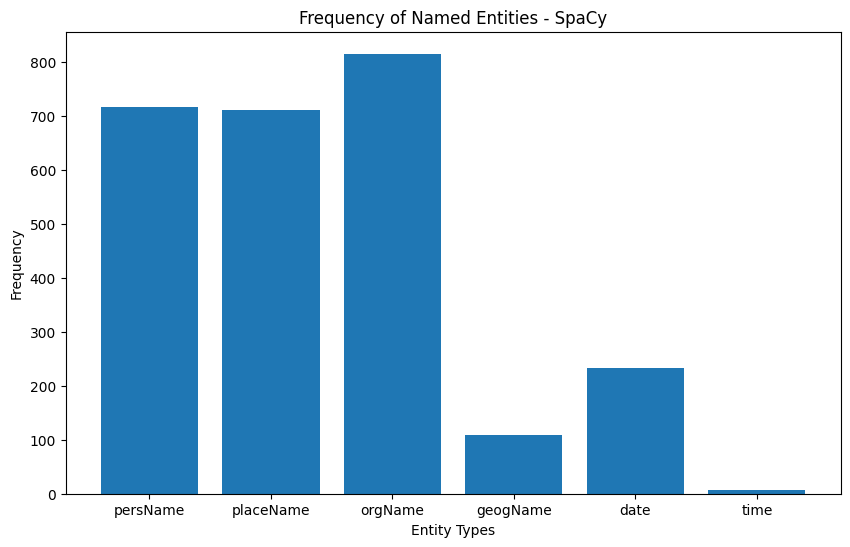

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(classes.keys(), [classes[key][1] for key in classes.keys()])
plt.title("Frequency of Named Entities - SpaCy")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.show()

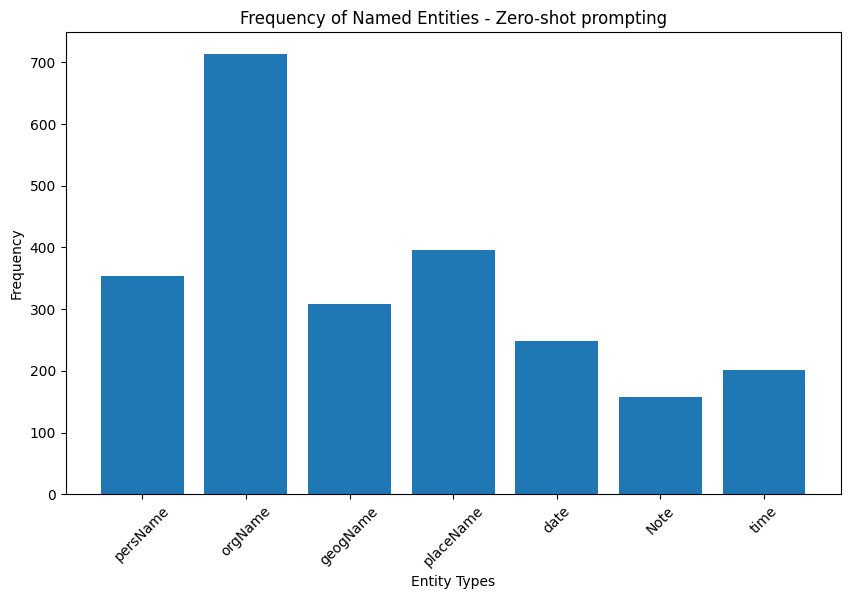

In [58]:
filtered_keys = [key for key in zero_shot_classes.keys() if zero_shot_classes[key][1] > 10]
filtered_values = [zero_shot_classes[key][1] for key in filtered_keys]
plt.figure(figsize=(10, 6))
plt.bar(filtered_keys, filtered_values)
plt.title("Frequency of Named Entities - Zero-shot prompting")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

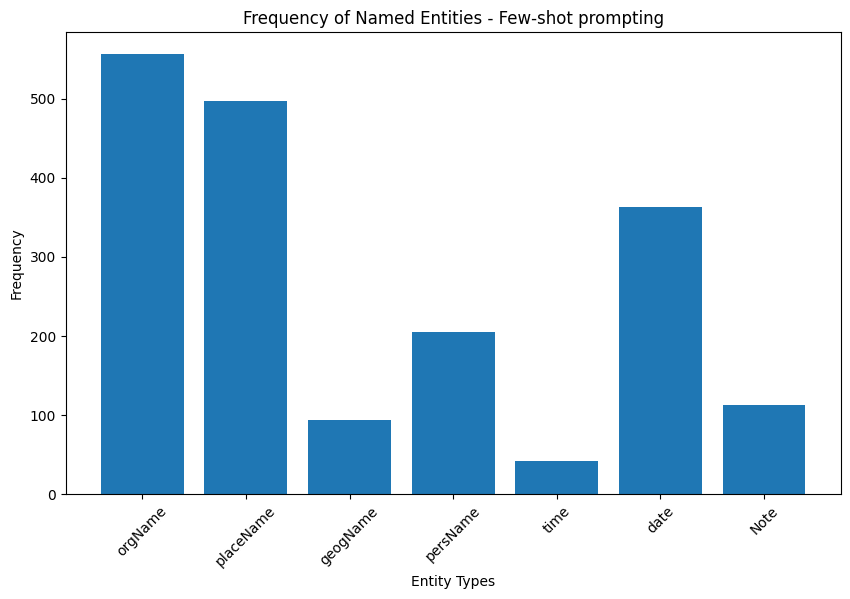

In [22]:
filtered_keys = [key for key in few_shot_classes.keys() if few_shot_classes[key][1] > 10]
filtered_values = [few_shot_classes[key][1] for key in filtered_keys]
plt.figure(figsize=(10, 6))
plt.bar(filtered_keys, filtered_values)
plt.title("Frequency of Named Entities - Few-shot prompting")
plt.xlabel("Entity Types")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [48]:
for ent_label, (entities, total_count) in classes.items():
    print(f"Entity Type: {ent_label}")
    most_frequent = Counter(entities).most_common(10)
    for entity, count in most_frequent:
        print(f"  {entity}: {count}")

Entity Type: persName
  Amazon: 17
  Netflix: 7
  OP: 6
  Walmart: 6
  Money: 5
  Quicken: 5
  Vanguard: 5
  Gdybyś: 5
  Trump: 5
  Rotha: 5
Entity Type: placeName
  USA: 120
  amerykański: 52
  Wielki Brytania: 33
  Stany Zjednoczone: 31
  Indie: 19
  Kanada: 16
  Amerykanów: 14
  Ameryka: 11
  Foods: 11
  Niemcy: 10
Entity Type: orgName
  IRA: 34
  ETF: 32
  IRS: 19
  Roth: 16
  Google: 15
  Apple: 14
  HSA: 14
  Roth IRA: 11
  MBA: 10
  GBP: 10
Entity Type: geogName
  Europa: 9
  Europejczyk: 3
  biały dom: 3
  Ameryka: 3
  Lucasfilm: 3
  azjatycki: 3
  Ameriprise: 3
  Gatorade: 2
  Bliski Wschodzie: 2
  Bliskiego wschód: 2
Entity Type: date
  10.: 7
  2008 rok: 6
  2014 rok.: 6
  2015 rok.: 6
  2008 rok.: 6
  2016: 6
  2013 rok: 5
  15 kwiecień: 5
  2013 rok.: 5
  2012: 5
Entity Type: time
  7.: 2
  25: 1
  10 rano: 1
  15 po południe: 1
  godzina 14.: 1
  00: 1


In [49]:
for ent_label, (entities, total_count) in zero_shot_classes.items():
    print(f"Entity Type: {ent_label}")
    most_frequent = Counter(entities).most_common(10)
    for entity, count in most_frequent:
        print(f"  {entity}: {count}")

Entity Type: persName
  Trump: 5
  ja: 4
  Ciebie: 4
  Steve Jobs: 3
  żona: 3
  Warren Buffett: 3
  Obama: 3
  Arthur Anderson: 2
  Joe: 2
  matka: 2
Entity Type: orgName
  IRS: 26
  bank: 15
  Amazon: 12
  Google: 10
  Apple: 8
  firma: 8
  banki: 7
  Reddit: 7
  PayPal: 6
  Microsoft: 6
Entity Type: geogName
  USA: 44
  Wielka Brytania: 24
  Ameryka: 15
  Stany Zjednoczone: 9
  Kanada: 9
  Europa: 8
  Nowy Jork: 5
  Izrael: 4
  Meksyk: 3
  Chiny: 3
Entity Type: placeName
  USA: 37
  Polska: 12
  Stany Zjednoczone: 9
  Wielka Brytania: 8
  Kanada: 8
  Ameryka: 8
  dom: 6
  Europa: 6
  Indie: 6
  Nowy Jork: 5
Entity Type: date
  2008: 8
  2012: 7
  2014: 5
  2013: 5
  2017: 4
  2011: 3
  2005: 3
  2009: 3
  2015: 3
  2016: 3
Entity Type: Note
  'persName': 8
  There are no specific calendar dates mentioned in the text.: 6
  There are no specific calendar dates mentioned in the text: 5
  There are no named entities in the provided text.: 4
  'orgName': 4
  'time'.: 4
  'geogName': 3
  

In [23]:
for ent_label, (entities, total_count) in few_shot_classes.items():
    print(f"Entity Type: {ent_label}")
    most_frequent = Counter(entities).most_common(10)
    for entity, count in most_frequent:
        print(f"  {entity}: {count}")

Entity Type: orgName
  Międzynarodowy Fundusz Walutowy (IMF): 17
  IRS: 16
  Amazon: 10
  Google: 8
  Apple: 7
  bank: 7
  Walmart: 7
  Microsoft: 6
  Netflix: 6
  PayPal: 4
Entity Type: placeName
  USA: 33
  Polska: 23
  Węgry: 22
  Czechy: 21
  Wielka Brytania: 20
  Ameryka: 11
  Stany Zjednoczone: 10
  Kanada: 10
  Nowa Zelandia: 8
  Europa Środkowo-Wschodnia: 8
Entity Type: geogName
  Europa Środkowo-Wschodnia: 14
  Ocean Atlantycki: 12
  USA: 10
  Europa: 7
  Wielka Brytania: 7
  Ameryka: 4
  Kanada: 3
  '': 2
  "": 2
  Brak: 1
Entity Type: persName
  Tim Cook: 9
  James Cook: 7
  "": 4
  Trump: 3
  (brak): 2
  Bob: 2
  Bernie Sanders: 2
  Warren Buffett: 2
  Obama: 2
  Demoulas: 2
Entity Type: time
  "": 4
  '': 3
  (brak): 2
  godzina: 2
  10:00: 1
  godzinie 10:00: 1
  48 godzin: 1
  Brak: 1
  (brak wzmianek o konkretnych czasach): 1
  czymś w rodzaju wielkiego spowolnienia: 1
Entity Type: date
  2023: 81
  2024: 67
  1769: 25
  2017: 10
  2014: 8
  2008: 8
  2013: 7
  2015: 7


In [51]:
all_entities = []
for ent_label, (entities, _) in classes.items():
    for entity, count in entities.items():
        all_entities.append((entity, count, ent_label))

sorted_entities = sorted(all_entities, key=lambda x: x[1], reverse=True)

print(f"{'Entity':<30} {'Count':<10} {'Type'}")
print("-" * 50)
for entity, count, ent_label in sorted_entities[:50]:
    print(f"{entity:<30} {count:<10} {ent_label}")

Entity                         Count      Type
--------------------------------------------------
USA                            120        placeName
amerykański                    52         placeName
IRA                            34         orgName
Wielki Brytania                33         placeName
ETF                            32         orgName
Stany Zjednoczone              31         placeName
Indie                          19         placeName
IRS                            19         orgName
Amazon                         17         persName
Kanada                         16         placeName
Roth                           16         orgName
Google                         15         orgName
Amerykanów                     14         placeName
Apple                          14         orgName
HSA                            14         orgName
Ameryka                        11         placeName
Foods                          11         placeName
Roth IRA                       11

In [52]:
all_entities = []
for ent_label, (entities, _) in zero_shot_classes.items():
    for entity, count in entities.items():
        all_entities.append((entity, count, ent_label))

sorted_entities = sorted(all_entities, key=lambda x: x[1], reverse=True)

print(f"{'Entity':<30} {'Count':<10} {'Type'}")
print("-" * 50)
for entity, count, ent_label in sorted_entities[:50]:
    print(f"{entity:<30} {count:<10} {ent_label}")

Entity                         Count      Type
--------------------------------------------------
USA                            44         geogName
USA                            37         placeName
IRS                            26         orgName
Wielka Brytania                24         geogName
bank                           15         orgName
Ameryka                        15         geogName
Amazon                         12         orgName
Polska                         12         placeName
Google                         10         orgName
Stany Zjednoczone              9          geogName
Kanada                         9          geogName
Stany Zjednoczone              9          placeName
Apple                          8          orgName
firma                          8          orgName
Europa                         8          geogName
Wielka Brytania                8          placeName
Kanada                         8          placeName
Ameryka                        8    

In [24]:
all_entities = []
for ent_label, (entities, _) in few_shot_classes.items():
    for entity, count in entities.items():
        all_entities.append((entity, count, ent_label))

sorted_entities = sorted(all_entities, key=lambda x: x[1], reverse=True)

print(f"{'Entity':<30} {'Count':<10} {'Type'}")
print("-" * 50)
for entity, count, ent_label in sorted_entities[:50]:
    print(f"{entity:<30} {count:<10} {ent_label}")

Entity                         Count      Type
--------------------------------------------------
2023                           81         date
2024                           67         date
USA                            33         placeName
1769                           25         date
Polska                         23         placeName
Węgry                          22         placeName
Czechy                         21         placeName
Wielka Brytania                20         placeName
Międzynarodowy Fundusz Walutowy (IMF) 17         orgName
IRS                            16         orgName
Europa Środkowo-Wschodnia      14         geogName
Ocean Atlantycki               12         geogName
Ameryka                        11         placeName
Amazon                         10         orgName
Stany Zjednoczone              10         placeName
Kanada                         10         placeName
USA                            10         geogName
2017                           10  

Zarówno w przypadku zastosowania SpaCy, jak i modelu Llama najczęściej rozpoznawaną kategorią były nazwy organizacji. LLM lepiej poradził sobie z rozpozawaniem dat i czasu. Problemem w przypadku użycia modelu językowego było uzyskanie odpowiedniej struktury odpowiedzi. Mimo określaenia zasad w prompcie, zdarzały się odpowiedzi o odmiennej strukturze, co z kolei powodowały problemy z parsowaniem i uwzględnienie nieporządanych odpowiedzi. Innym problemem związanym z użyciem LLM było generowanie przez model dodatkowych kategorii, przez co liczba kategorii rozpoznanych przez model jest dużo większa w porównaniu ze SpaCy, gdzie liczba kategorii jest z góry zdefiniowana. Natomiast analizując przyporządkowanie encji do głównych kategorii (zdefiniowanych w SpaCy) wydaje się, że klasyfikacja dokonana zapomocą modelu jest bardziej spójna i uzasadniona, zwłaszcza w przypadku podejścia few-shot prompting. Jednak można zauważyć, że z tym podejściem wiąże się problem nadmiernego sugerowania się przykładami umieszczonymi w prompcie, w związku z czym model ma tendencję do rozpoznawania encji podanych w przykładach, nawet jeśli nie pojawiają się w tekstach.

## Build a simple evaluation pipeline

In [27]:
true_df = pd.read_excel('/kaggle/input/named-entities/entities.xlsx')
true_df.head()

,text,entities
0,"Kapitalizacja rynkowa jest jednym ze sposobów reprezentowania wartości firmy. Jeśli więc firma ma 10 milionów akcji, z których każda jest warta 100 dolarów, to jej kapitalizacja rynkowa wynosi 1 miliard. Spółki o dużej kapitalizacji są zwykle większe i bardziej stabilne. Spółki o małej kapitalizacji są mniejsze, co wskazuje na większą zmienność. Więc jeśli chcesz bardziej agresywnych inwestycji, możesz chcieć zainwestować w spółki o małej kapitalizacji, a jeśli będziesz ostrożny, to spółki o dużej kapitalizacji mogą być twoim przyjacielem.",NaN
1,"To bardzo mi przypomina Starbucks UK, gdzie Starbucks UK praktycznie nie ma zerowego zysku na papierze, ponieważ płaci to wszystko Starbucks US jako różne opłaty. To w zasadzie zalegalizowane korporacyjne pranie pieniędzy, ponieważ pieniądze tak naprawdę zmieniają ręce tylko na papierze.","orgName: Starbucks UK, Starbucks US"
2,"Nie mam wiele do dodania, poza tym, że Twój podpis nie jest wymagany do przetworzenia opłaty. Podpisy są przechowywane w aktach, aby zachować ważność w przypadku zakwestionowania zarzutu. Twój podpis nie jest przechowywany w jakiejś magicznej bazie danych z oprogramowaniem do rozpoznawania podpisów. Jeśli narysujesz rekina w sekcji podpisu na paragonie, nie powstrzyma to przetworzenia opłaty. W rzeczywistości wielu handlowców nawet nie zadaje sobie trudu wymaganie podpisu poniżej pewnego progu. Istnieje wiele zakulisowych ulepszeń przetwarzania oferowanych przez układ EMV; mianowicie zapobieganie skimmingowi i duplikacji numeru karty poprzez szyfrowane podpisywanie transakcji. Chociaż wymaganie kodu PIN stanowi dodatkową warstwę bezpieczeństwa, proste przetwarzanie za pomocą chipa znacznie poprawia narzędzia do zapobiegania oszustwom w sieci w sposób, który jest prawie całkowicie przejrzysty dla użytkownika. Do twojego punktu, jeśli twój portfel zostanie zgubiony, a narzucający się trzyma twoją fizyczną kartę, nie ma poprawy w zakresie zwalczania oszustw. W każdym razie nie masz żadnej odpowiedzialności za oszustwa w USA.",orgName: EMV; geogName: USA
3,"Tak, więc oba te nie są prawdziwe. Cięcie funduszy na te rzeczy drastycznie zmienia ich zdolność do świadczenia usług, a Departament Energii, Departament Edukacji, EPA – wszystkie one świadczą pilnie potrzebne usługi. To nie tylko cięcia budżetowe. Zmiana polityki w celu zmniejszenia skuteczności, celowe zaniżanie personelu, eliminacja zdolności naukowców do przekazywania wyników opinii publicznej. Dostęp do danych rządowych stał się zauważalnie trudniejszy, odkąd ta administracja zaczęła demontować te organizacje","orgName: Departament Energii, Departament Edukacji, EPA"
4,"Myślę, że to było 99 lat, jeśli pamiętam. Ale masz rację we wszystkim innym. Jeśli dobrze pamiętam, to też tylko na miliard. Niewiele, jeśli wziąć pod uwagę, że Chicago jest trzecim co do wielkości miastem i to od stulecia. Kto by pomyślał, że to dobry pomysł, żeby sprzedać te prawa Nie mam pojęcia, ale zachowywali się jak bandyta",placeName: Chicago


In [28]:
spacy_results = []

for document in true_df['text']:
    doc = nlp(document)
    entities_dict = defaultdict(list)

    for ent in doc.ents:
        entities_dict[ent.label_].append(ent.lemma_)

    formatted_entities = [f"{label}: {', '.join(set(entities))}" for label, entities in entities_dict.items()]

    spacy_results.append({
        'text': document,
        'entities': ", ".join(formatted_entities)  
    })

In [29]:
spacy_pred_df = pd.DataFrame(spacy_results)
spacy_pred_df.to_csv('spacy_pred_df.csv', index=False)

In [30]:
spacy_pred_df

,text,entities
0,"Kapitalizacja rynkowa jest jednym ze sposobów reprezentowania wartości firmy. Jeśli więc firma ma 10 milionów akcji, z których każda jest warta 100 dolarów, to jej kapitalizacja rynkowa wynosi 1 miliard. Spółki o dużej kapitalizacji są zwykle większe i bardziej stabilne. Spółki o małej kapitalizacji są mniejsze, co wskazuje na większą zmienność. Więc jeśli chcesz bardziej agresywnych inwestycji, możesz chcieć zainwestować w spółki o małej kapitalizacji, a jeśli będziesz ostrożny, to spółki o dużej kapitalizacji mogą być twoim przyjacielem.",
1,"To bardzo mi przypomina Starbucks UK, gdzie Starbucks UK praktycznie nie ma zerowego zysku na papierze, ponieważ płaci to wszystko Starbucks US jako różne opłaty. To w zasadzie zalegalizowane korporacyjne pranie pieniędzy, ponieważ pieniądze tak naprawdę zmieniają ręce tylko na papierze.","persName: Starbucks UK, orgName: Starbucks US, Starbucks UK"
2,"Nie mam wiele do dodania, poza tym, że Twój podpis nie jest wymagany do przetworzenia opłaty. Podpisy są przechowywane w aktach, aby zachować ważność w przypadku zakwestionowania zarzutu. Twój podpis nie jest przechowywany w jakiejś magicznej bazie danych z oprogramowaniem do rozpoznawania podpisów. Jeśli narysujesz rekina w sekcji podpisu na paragonie, nie powstrzyma to przetworzenia opłaty. W rzeczywistości wielu handlowców nawet nie zadaje sobie trudu wymaganie podpisu poniżej pewnego progu. Istnieje wiele zakulisowych ulepszeń przetwarzania oferowanych przez układ EMV; mianowicie zapobieganie skimmingowi i duplikacji numeru karty poprzez szyfrowane podpisywanie transakcji. Chociaż wymaganie kodu PIN stanowi dodatkową warstwę bezpieczeństwa, proste przetwarzanie za pomocą chipa znacznie poprawia narzędzia do zapobiegania oszustwom w sieci w sposób, który jest prawie całkowicie przejrzysty dla użytkownika. Do twojego punktu, jeśli twój portfel zostanie zgubiony, a narzucający się trzyma twoją fizyczną kartę, nie ma poprawy w zakresie zwalczania oszustw. W każdym razie nie masz żadnej odpowiedzialności za oszustwa w USA.","orgName: PIN, EMV, placeName: USA"
3,"Tak, więc oba te nie są prawdziwe. Cięcie funduszy na te rzeczy drastycznie zmienia ich zdolność do świadczenia usług, a Departament Energii, Departament Edukacji, EPA – wszystkie one świadczą pilnie potrzebne usługi. To nie tylko cięcia budżetowe. Zmiana polityki w celu zmniejszenia skuteczności, celowe zaniżanie personelu, eliminacja zdolności naukowców do przekazywania wyników opinii publicznej. Dostęp do danych rządowych stał się zauważalnie trudniejszy, odkąd ta administracja zaczęła demontować te organizacje","orgName: Departament Energia, departament Edukacja"
4,"Myślę, że to było 99 lat, jeśli pamiętam. Ale masz rację we wszystkim innym. Jeśli dobrze pamiętam, to też tylko na miliard. Niewiele, jeśli wziąć pod uwagę, że Chicago jest trzecim co do wielkości miastem i to od stulecia. Kto by pomyślał, że to dobry pomysł, żeby sprzedać te prawa Nie mam pojęcia, ale zachowywali się jak bandyta",placeName: Chicago
5,"I o to chodzi, niczego nie wygrałeś. Nie jesteś częścią zespołu. Masz po prostu pranie mózgu przez politykę, którą wybierasz, by się odizolować. Trump wygrał, nie ty, i wygrał przez przypadek i okłamując ludzi, którzy go głupio wspierali. Spodziewał się przegranej, a dzień przed i we wtorek przed wyborami jego kampania promowała narrację, że demokraci oszukiwali, aby wygrać. Wszyscy, kurwa, przegraliśmy. Przegrałeś gorzej niż ja, ponieważ nadal pokładasz nadzieję w kłamliwym szumowinie, który nie ma żadnych moralności, skrupułów ani poczucia przyzwoitości, a przyznanie się do tego monumentalnego pojebania jest zbyt bolesne.",persName: Trump
6,"Nie mogę mówić konkretnie o systemie Tangerine, ale korzystałem z podobnych systemów za pośrednictwem Bank of America i Chase (oba z siedzibą w USA). Wygląda na to, że moje doświadczenie w zakresie weryfikacji tożsamości było bardzo podobne i teraz używam tego do regularnego płacenia kilku kontrahentom. Jak do

In [31]:
llm_results = []
for i, text in enumerate(true_df['text']):
    response = extract_entities_from_text(text, zero_shot_prompt)
    print(response)
    llm_results.append({
        'text': text,
        'entities': extract_valid_entities(response)
    })

[GIN] 2024/12/09 - 12:57:46 | 200 |   2.19265641s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: 
persName: 
placeName: 
time: 

(Nie ma zidentyfikowanych jednostek nazwowych w tekście.)
[GIN] 2024/12/09 - 12:57:47 | 200 |  1.160339017s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: UK, US
placeName: Starbucks, 
persName: 
time:
[GIN] 2024/12/09 - 12:57:49 | 200 |  1.816793427s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: USA
orgName: 
persName: 
placeName: 
time:
[GIN] 2024/12/09 - 12:57:51 | 200 |   1.94070834s |       127.0.0.1 | POST     "/api/chat"
Here is the list of named entities categorized:

date: 

geogName: 

orgName: Departament Energii, Departament Edukacji, EPA

persName: 

placeName: 

time:
[GIN] 2024/12/09 - 12:57:52 | 200 |  1.408848657s |       127.0.0.1 | POST     "/api/chat"
date: 99 lat, miliard
geogName: 
orgName: 
persName: 
placeName: Chicago
[GIN] 2024/12/09 - 12:57:54 | 200 |  1.243322383s |       127.0.0.1 | POST

In [32]:
zero_shot_pred_df = pd.DataFrame(llm_results)
zero_shot_pred_df.to_csv('zero_shot_pred_df.csv', index=False)

In [33]:
zero_shot_pred_df

,text,entities
0,"Kapitalizacja rynkowa jest jednym ze sposobów reprezentowania wartości firmy. Jeśli więc firma ma 10 milionów akcji, z których każda jest warta 100 dolarów, to jej kapitalizacja rynkowa wynosi 1 miliard. Spółki o dużej kapitalizacji są zwykle większe i bardziej stabilne. Spółki o małej kapitalizacji są mniejsze, co wskazuje na większą zmienność. Więc jeśli chcesz bardziej agresywnych inwestycji, możesz chcieć zainwestować w spółki o małej kapitalizacji, a jeśli będziesz ostrożny, to spółki o dużej kapitalizacji mogą być twoim przyjacielem.",
1,"To bardzo mi przypomina Starbucks UK, gdzie Starbucks UK praktycznie nie ma zerowego zysku na papierze, ponieważ płaci to wszystko Starbucks US jako różne opłaty. To w zasadzie zalegalizowane korporacyjne pranie pieniędzy, ponieważ pieniądze tak naprawdę zmieniają ręce tylko na papierze.","geogName: UK, US; placeName: Starbucks,"
2,"Nie mam wiele do dodania, poza tym, że Twój podpis nie jest wymagany do przetworzenia opłaty. Podpisy są przechowywane w aktach, aby zachować ważność w przypadku zakwestionowania zarzutu. Twój podpis nie jest przechowywany w jakiejś magicznej bazie danych z oprogramowaniem do rozpoznawania podpisów. Jeśli narysujesz rekina w sekcji podpisu na paragonie, nie powstrzyma to przetworzenia opłaty. W rzeczywistości wielu handlowców nawet nie zadaje sobie trudu wymaganie podpisu poniżej pewnego progu. Istnieje wiele zakulisowych ulepszeń przetwarzania oferowanych przez układ EMV; mianowicie zapobieganie skimmingowi i duplikacji numeru karty poprzez szyfrowane podpisywanie transakcji. Chociaż wymaganie kodu PIN stanowi dodatkową warstwę bezpieczeństwa, proste przetwarzanie za pomocą chipa znacznie poprawia narzędzia do zapobiegania oszustwom w sieci w sposób, który jest prawie całkowicie przejrzysty dla użytkownika. Do twojego punktu, jeśli twój portfel zostanie zgubiony, a narzucający się trzyma twoją fizyczną kartę, nie ma poprawy w zakresie zwalczania oszustw. W każdym razie nie masz żadnej odpowiedzialności za oszustwa w USA.",geogName: USA
3,"Tak, więc oba te nie są prawdziwe. Cięcie funduszy na te rzeczy drastycznie zmienia ich zdolność do świadczenia usług, a Departament Energii, Departament Edukacji, EPA – wszystkie one świadczą pilnie potrzebne usługi. To nie tylko cięcia budżetowe. Zmiana polityki w celu zmniejszenia skuteczności, celowe zaniżanie personelu, eliminacja zdolności naukowców do przekazywania wyników opinii publicznej. Dostęp do danych rządowych stał się zauważalnie trudniejszy, odkąd ta administracja zaczęła demontować te organizacje","orgName: Departament Energii, Departament Edukacji, EPA"
4,"Myślę, że to było 99 lat, jeśli pamiętam. Ale masz rację we wszystkim innym. Jeśli dobrze pamiętam, to też tylko na miliard. Niewiele, jeśli wziąć pod uwagę, że Chicago jest trzecim co do wielkości miastem i to od stulecia. Kto by pomyślał, że to dobry pomysł, żeby sprzedać te prawa Nie mam pojęcia, ale zachowywali się jak bandyta","date: 99 lat, miliard; placeName: Chicago"
5,"I o to chodzi, niczego nie wygrałeś. Nie jesteś częścią zespołu. Masz po prostu pranie mózgu przez politykę, którą wybierasz, by się odizolować. Trump wygrał, nie ty, i wygrał przez przypadek i okłamując ludzi, którzy go głupio wspierali. Spodziewał się przegranej, a dzień przed i we wtorek przed wyborami jego kampania promowała narrację, że demokraci oszukiwali, aby wygrać. Wszyscy, kurwa, przegraliśmy. Przegrałeś gorzej niż ja, ponieważ nadal pokładasz nadzieję w kłamliwym szumowinie, który nie ma żadnych moralności, skrupułów ani poczucia przyzwoitości, a przyznanie się do tego monumentalnego pojebania jest zbyt bolesne.","persName: Trump; time: dzień, we wtorek"
6,"Nie mogę mówić konkretnie o systemie Tangerine, ale korzystałem z podobnych systemów za pośrednictwem Bank of America i Chase (oba z siedzibą w USA). Wygląda na to, że moje doświadczenie w zakresie weryfikacji tożsamości było bardzo podobne i teraz używam tego do regularnego płacenia kilku kontra

In [34]:
llm_results = []
for i, text in enumerate(true_df['text']):
    response = extract_entities_from_text(text, few_shot_prompt)
    print(response)
    llm_results.append({
        'text': text,
        'entities': extract_valid_entities(response)
    })

[GIN] 2024/12/09 - 12:58:59 | 200 |  2.457277452s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: 
persName: 
placeName: 
time:
[GIN] 2024/12/09 - 12:59:00 | 200 |  1.197043067s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: Starbucks UK, Starbucks US
placeName: 
time:
[GIN] 2024/12/09 - 12:59:02 | 200 |  1.832549676s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: 
persName: 
placeName: 
time:
[GIN] 2024/12/09 - 12:59:04 | 200 |  1.727502198s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: Departament Energii, Departament Edukacji, EPA
persName: 
placeName: 
time:
[GIN] 2024/12/09 - 12:59:05 | 200 |  1.170319943s |       127.0.0.1 | POST     "/api/chat"
date: 99 lat
persName: 
placeName: Chicago
time:
[GIN] 2024/12/09 - 12:59:06 | 200 |  1.408926686s |       127.0.0.1 | POST     "/api/chat"
date: 
geogName: 
orgName: 
persName: Trump
placeName: 
time:
[GIN] 2024/12/09 - 12:59:08 | 200 |  1.521409443s |   

In [35]:
few_shot_pred_df = pd.DataFrame(llm_results)
few_shot_pred_df.to_csv('few_shot_pred_df.csv', index=False)

In [36]:
few_shot_pred_df

,text,entities
0,"Kapitalizacja rynkowa jest jednym ze sposobów reprezentowania wartości firmy. Jeśli więc firma ma 10 milionów akcji, z których każda jest warta 100 dolarów, to jej kapitalizacja rynkowa wynosi 1 miliard. Spółki o dużej kapitalizacji są zwykle większe i bardziej stabilne. Spółki o małej kapitalizacji są mniejsze, co wskazuje na większą zmienność. Więc jeśli chcesz bardziej agresywnych inwestycji, możesz chcieć zainwestować w spółki o małej kapitalizacji, a jeśli będziesz ostrożny, to spółki o dużej kapitalizacji mogą być twoim przyjacielem.",
1,"To bardzo mi przypomina Starbucks UK, gdzie Starbucks UK praktycznie nie ma zerowego zysku na papierze, ponieważ płaci to wszystko Starbucks US jako różne opłaty. To w zasadzie zalegalizowane korporacyjne pranie pieniędzy, ponieważ pieniądze tak naprawdę zmieniają ręce tylko na papierze.","orgName: Starbucks UK, Starbucks US"
2,"Nie mam wiele do dodania, poza tym, że Twój podpis nie jest wymagany do przetworzenia opłaty. Podpisy są przechowywane w aktach, aby zachować ważność w przypadku zakwestionowania zarzutu. Twój podpis nie jest przechowywany w jakiejś magicznej bazie danych z oprogramowaniem do rozpoznawania podpisów. Jeśli narysujesz rekina w sekcji podpisu na paragonie, nie powstrzyma to przetworzenia opłaty. W rzeczywistości wielu handlowców nawet nie zadaje sobie trudu wymaganie podpisu poniżej pewnego progu. Istnieje wiele zakulisowych ulepszeń przetwarzania oferowanych przez układ EMV; mianowicie zapobieganie skimmingowi i duplikacji numeru karty poprzez szyfrowane podpisywanie transakcji. Chociaż wymaganie kodu PIN stanowi dodatkową warstwę bezpieczeństwa, proste przetwarzanie za pomocą chipa znacznie poprawia narzędzia do zapobiegania oszustwom w sieci w sposób, który jest prawie całkowicie przejrzysty dla użytkownika. Do twojego punktu, jeśli twój portfel zostanie zgubiony, a narzucający się trzyma twoją fizyczną kartę, nie ma poprawy w zakresie zwalczania oszustw. W każdym razie nie masz żadnej odpowiedzialności za oszustwa w USA.",
3,"Tak, więc oba te nie są prawdziwe. Cięcie funduszy na te rzeczy drastycznie zmienia ich zdolność do świadczenia usług, a Departament Energii, Departament Edukacji, EPA – wszystkie one świadczą pilnie potrzebne usługi. To nie tylko cięcia budżetowe. Zmiana polityki w celu zmniejszenia skuteczności, celowe zaniżanie personelu, eliminacja zdolności naukowców do przekazywania wyników opinii publicznej. Dostęp do danych rządowych stał się zauważalnie trudniejszy, odkąd ta administracja zaczęła demontować te organizacje","orgName: Departament Energii, Departament Edukacji, EPA"
4,"Myślę, że to było 99 lat, jeśli pamiętam. Ale masz rację we wszystkim innym. Jeśli dobrze pamiętam, to też tylko na miliard. Niewiele, jeśli wziąć pod uwagę, że Chicago jest trzecim co do wielkości miastem i to od stulecia. Kto by pomyślał, że to dobry pomysł, żeby sprzedać te prawa Nie mam pojęcia, ale zachowywali się jak bandyta",date: 99 lat; placeName: Chicago
5,"I o to chodzi, niczego nie wygrałeś. Nie jesteś częścią zespołu. Masz po prostu pranie mózgu przez politykę, którą wybierasz, by się odizolować. Trump wygrał, nie ty, i wygrał przez przypadek i okłamując ludzi, którzy go głupio wspierali. Spodziewał się przegranej, a dzień przed i we wtorek przed wyborami jego kampania promowała narrację, że demokraci oszukiwali, aby wygrać. Wszyscy, kurwa, przegraliśmy. Przegrałeś gorzej niż ja, ponieważ nadal pokładasz nadzieję w kłamliwym szumowinie, który nie ma żadnych moralności, skrupułów ani poczucia przyzwoitości, a przyznanie się do tego monumentalnego pojebania jest zbyt bolesne.",persName: Trump
6,"Nie mogę mówić konkretnie o systemie Tangerine, ale korzystałem z podobnych systemów za pośrednictwem Bank of America i Chase (oba z siedzibą w USA). Wygląda na to, że moje doświadczenie w zakresie weryfikacji tożsamości było bardzo podobne i teraz używam tego do regularnego płacenia kilku kontrahentom. Jak dotąd żadnych problemów.","geogName: USA; 

In [37]:
def parse_entities(entities_str):
    entities_dict = {}
    if not isinstance(entities_str, str) or not entities_str:
        return entities_dict
    
    class_entries = [entry.strip() for entry in entities_str.split(';') if entry]
    for entry in class_entries:
        if ':' in entry:
            class_name, entity_list = entry.split(':', 1)
            class_name = class_name.strip()
            entities = [e.strip() for e in entity_list.split(',') if e.strip()]
            entities_dict[class_name] = entities
    return entities_dict

In [ ]:
def calculate_metrics(true_df, pred_df):
    all_categories = set()
    
    true_df['parsed_entities'] = true_df['entities'].apply(parse_entities)
    pred_df['parsed_entities'] = pred_df['entities'].apply(parse_entities)

    for entities in true_df['parsed_entities']:
        all_categories.update(entities.keys())
    
    results = {category: {'TP': 0, 'FP': 0, 'FN': 0} for category in all_categories}

    for i in range(len(true_df)):
        true_entities = true_df.loc[i, 'parsed_entities']
        pred_entities = pred_df.loc[i, 'parsed_entities'] if i < len(pred_df) else {}

        for category in all_categories:
            true_set = set(true_entities.get(category, []))
            pred_set = set(pred_entities.get(category, []))
            
            tp = len(true_set & pred_set)
            fp = len(pred_set - true_set)
            fn = len(true_set - pred_set)
            
            results[category]['TP'] += tp
            results[category]['FP'] += fp
            results[category]['FN'] += fn

    metrics = {}
    for category, counts in results.items():
        TP = counts['TP']
        FP = counts['FP']
        FN = counts['FN']
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[category] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'TP': TP,
            'FP': FP,
            'FN': FN
        }
    
    total_TP = sum(counts['TP'] for counts in results.values())
    total_FP = sum(counts['FP'] for counts in results.values())
    total_FN = sum(counts['FN'] for counts in results.values())
    
    overall_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    overall_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    
    metrics['overall'] = {
        'precision': overall_precision,
        'recall': overall_recall,
        'f1': overall_f1,
        'TP': total_TP,
        'FP': total_FP,
        'FN': total_FN
    }
    
    return pd.DataFrame(metrics).T

In [39]:
spacy_metrics_df = calculate_metrics(true_df, spacy_pred_df)
spacy_metrics_df

,precision,recall,f1,TP,FP,FN
date,0.000000,0.000000,0.000000,0.0,7.0,10.0
orgName,0.178571,0.084746,0.114943,5.0,23.0,54.0
geogName,0.000000,0.000000,0.000000,0.0,11.0,1.0
placeName,0.175000,0.184211,0.179487,7.0,33.0,31.0
persName,0.191176,0.371429,0.252427,13.0,55.0,22.0
overall,0.162338,0.174825,0.168350,25.0,129.0,118.0


In [40]:
zero_shot_metrics_df = calculate_metrics(true_df, zero_shot_pred_df)
zero_shot_metrics_df

,precision,recall,f1,TP,FP,FN
date,0.375000,0.600000,0.461538,6.0,10.0,4.0
orgName,0.700000,0.355932,0.471910,21.0,9.0,38.0
geogName,0.041667,1.000000,0.080000,1.0,23.0,0.0
placeName,0.375000,0.394737,0.384615,15.0,25.0,23.0
persName,0.685714,0.685714,0.685714,24.0,11.0,11.0
overall,0.462069,0.468531,0.465278,67.0,78.0,76.0


In [41]:
few_shot_metrics_df = calculate_metrics(true_df, few_shot_pred_df)
few_shot_metrics_df

,precision,recall,f1,TP,FP,FN
date,0.272727,0.600000,0.375000,6.0,16.0,4.0
orgName,0.787879,0.440678,0.565217,26.0,7.0,33.0
geogName,0.000000,0.000000,0.000000,0.0,6.0,1.0
placeName,0.529412,0.710526,0.606742,27.0,24.0,11.0
persName,0.636364,0.600000,0.617647,21.0,12.0,14.0
overall,0.551724,0.559441,0.555556,80.0,65.0,63.0


## Questions

1. How does the performance of LLM-based NER compare to traditional approaches? What are the trade-offs in terms of accuracy, speed, and resource usage?

    Analizując wartości metryk, widać wyraźną przewagę podejścia opartego o LLM w porównaniu z użyciem SpaCy, jednak przetwarzanie dużej ilości tekstu za pomocą modeli językowych jest bardzo czasochłonne i wymaga odpowiednich zasobów. Przy uruchomieniu modelu llama3.1 lokalnie czas potrzebny do przetworzenia jednego przykładu z korpusu wynosił ponad minutę, a w przypadku podejścia few-shot nawet kilka minut, podczas gdy przetworzenie tysiąca przykładów za pomocą SpaCy zajmuje ok. 30 sekund. 
    
2. Which prompting strategy proved most effective for NER and classification tasks? Why?

    Najlepsze rezultaty zostały osiągnięte dla podejścia few-shot. Podanie w prompcie przkładów poprawnego rozpoznawani i klasyfikowania encji poprawiło dokładność odpowiedzi modelu. Z drugiej strony zauważalne było też to, że w niektórych przypadkach model zbyt mocno sugerował się przykładami umieszczonymi w prompcie i umieszczał w odpowiedzi encje podane w przykłądach, nawet jeśli nie znajdowały się w tekście.

3. What are the limitations and potential biases of using LLMs for NER and classification?

    Problemem w użyciu LLMów do rozpoznawania i klasyfikacji encji jest tendencja modeli do tworzenia innych kategorii niż te określone w prompcie, generowanie dodatkowych, niepotrzebnych informacji, które utrudniają parsowanie i dalsze przetwarzanie odpowiedzi modelu, a także nadmierne sugerowanie się przykładami umieszczonymi w prompcie. Poza tym skuteczność modeli w tego typu zadaniach bardzo mocno zależy od sformułowania promptu, a nawet dla tego samego promptu odpowiedzi modelu za każdym razem będą się różnić, dlatego trudno jest jednoznacznie ocenić skuteczność modeli dla tego zadania.

4. In what scenarios would you recommend using traditional NER vs. LLM-based approaches?

    Zastosowanie LLMów może być przydatne, jeżeli nie mamy z góry zdefiniowanych kategorii i chcemy, aby model rozpoznał encje, a następnie sam je skategoryzował lub gdy interesuje nas rozpoznawanie specyficznych kategorii, które nie są zdefiniowane w innych narzędziach. Jeśli jednak mamy do przetworzenia duże ilości tekstu i zależy nam na czasie, a mniej na dokładności i specyficzności rozpoznawanych klas, wówczas lepszym rozwiązaniem będzie podejście klasyczne. 
